In [1]:
# For better plotting
%matplotlib inline

# autoreload function - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import open3d
import numpy as np 
import matplotlib.pyplot as plt 
import copy
import time
import os
import sys
import collections

from utils.lib_plot import plot_cloud_2d, plot_cloud_3d, plot_cloud_2d3d, plot_2d_line_from_3d
from utils.lib_open3d_io import get_xyza, read_cloud, write_cloud
from utils.lib_cloud_proc import get_xy_from_latlon, downsample, filter_cloud
from utils.lib_cloud_proc import find_plannar_points_by_grid, find_plannar_points_by_kdtree
from utils.lib_plane import PlaneModel, fit_3D_line
from utils.lib_ransac import ransac
from utils.lib_clustering import Clusterer

t_start_running_this_jupyter_notebook = time.time()

# Define some common functions

In [3]:
def write_cloud_and_figure(filename, cloud):
    write_cloud(filename + '.pcd', cloud)
    plt.savefig(filename + '.jpg')

def split_into_columns(X): 
    ''' Split X into columns to form a list'''
    N_cols = X.shape[1]
    return [i.ravel() for i in np.hsplit(X, N_cols)]

def get_3d_line_equation(vec, p):
    ''' Get the string of 3d line equation from line parameters '''
    # vec: line direction
    # p: a point on the line
    vars = ['x', 'y', 'z']
    eqs = []
    for i in range(3):
        sign = '-' if p[i] > 0 else '+'
        s = "({}{}{:.2f})/({:.5f})".format(vars[i], sign, abs(p[i]), vec[i])
        eqs.append(s)
    return " == ".join(eqs)

# Create folder to store result
RES_FOLDER = "./result/"
if not os.path.exists(RES_FOLDER):
    os.makedirs(RES_FOLDER)

# Read cloud

In [4]:
# Read cloud data
# Each point has 4 attributes: [lat, lon, height, alpha (point intensity)]

filename_source_cloud = "data/final_project_point_cloud.fuse"
data = np.loadtxt(filename_source_cloud).astype(np.float32)
lats, lons, h, alpha = split_into_columns(data)


# Convert from (lat, lon) to local Cartesian (x, y) coordinate
xs, ys = get_xy_from_latlon(lats, lons)
xyza_src = np.column_stack((xs, ys, h, np.minimum(1.0, alpha/100.0)))

(430736, 4)
Time cost of plotting 2D/3D point cloud = 0.74 seconds


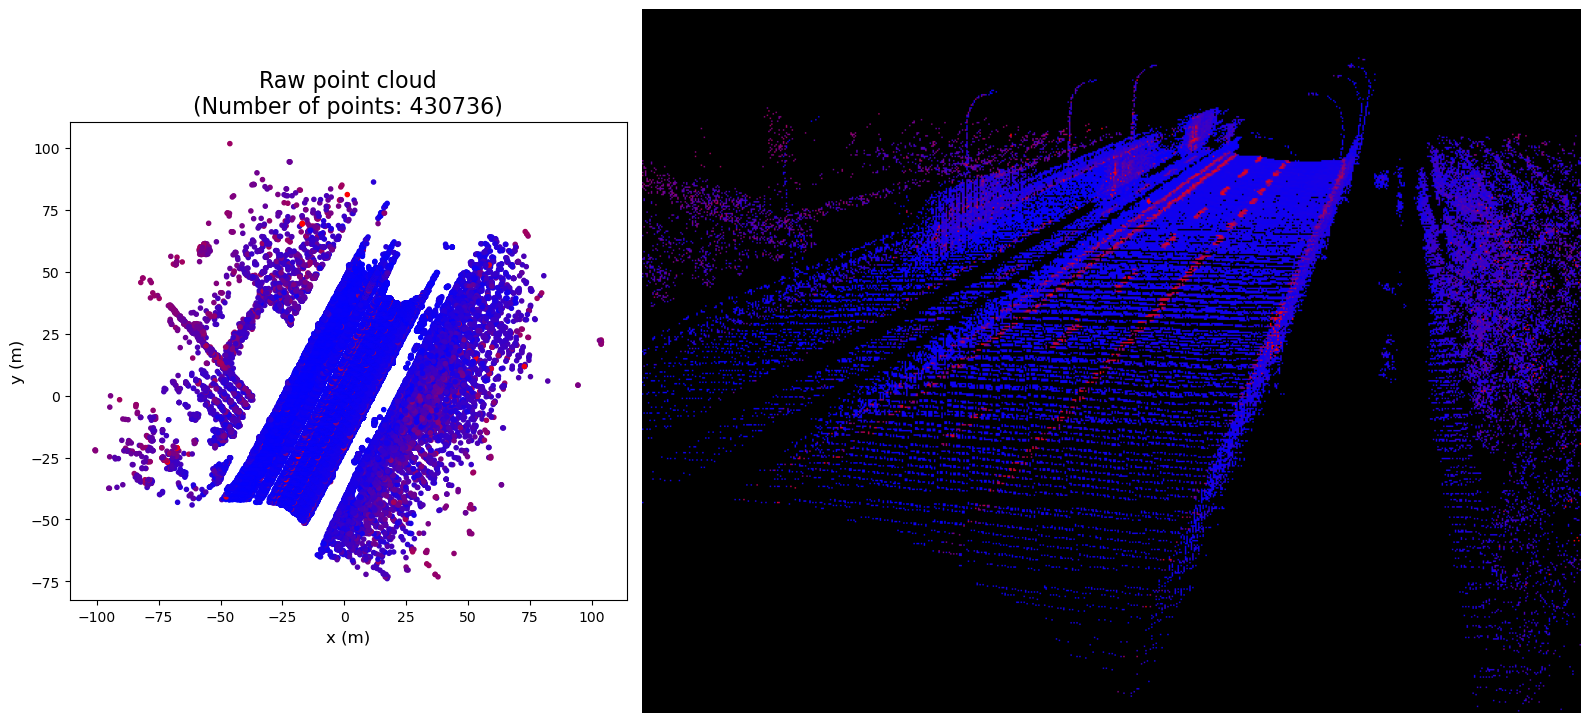

In [5]:
# Plot and save
plot_cloud_2d3d(xyza_src, title='Raw point cloud')
write_cloud_and_figure('result/1_xyza_src', xyza_src)
plt.show()

# Preprocess cloud: downsample + radius filter

In [6]:
xyza_down = downsample(xyza_src, voxel_size=0.1, option='max_alpha')

print("Downsample: {} --> {}".format(
    xyza_src.shape[0], xyza_down.shape[0]))
    
xyza = filter_cloud(xyza_src, nb_points=2, radius=0.5)
# xyza = filter_cloud(xyza_down, nb_points=2, radius=0.5)

print("Filtering:  {} --> {}".format(
    xyza_down.shape[0], xyza.shape[0]))

Downsample: 430736 --> 90272
Filtering:  90272 --> 425276


(425276, 4)
Time cost of plotting 2D/3D point cloud = 0.70 seconds


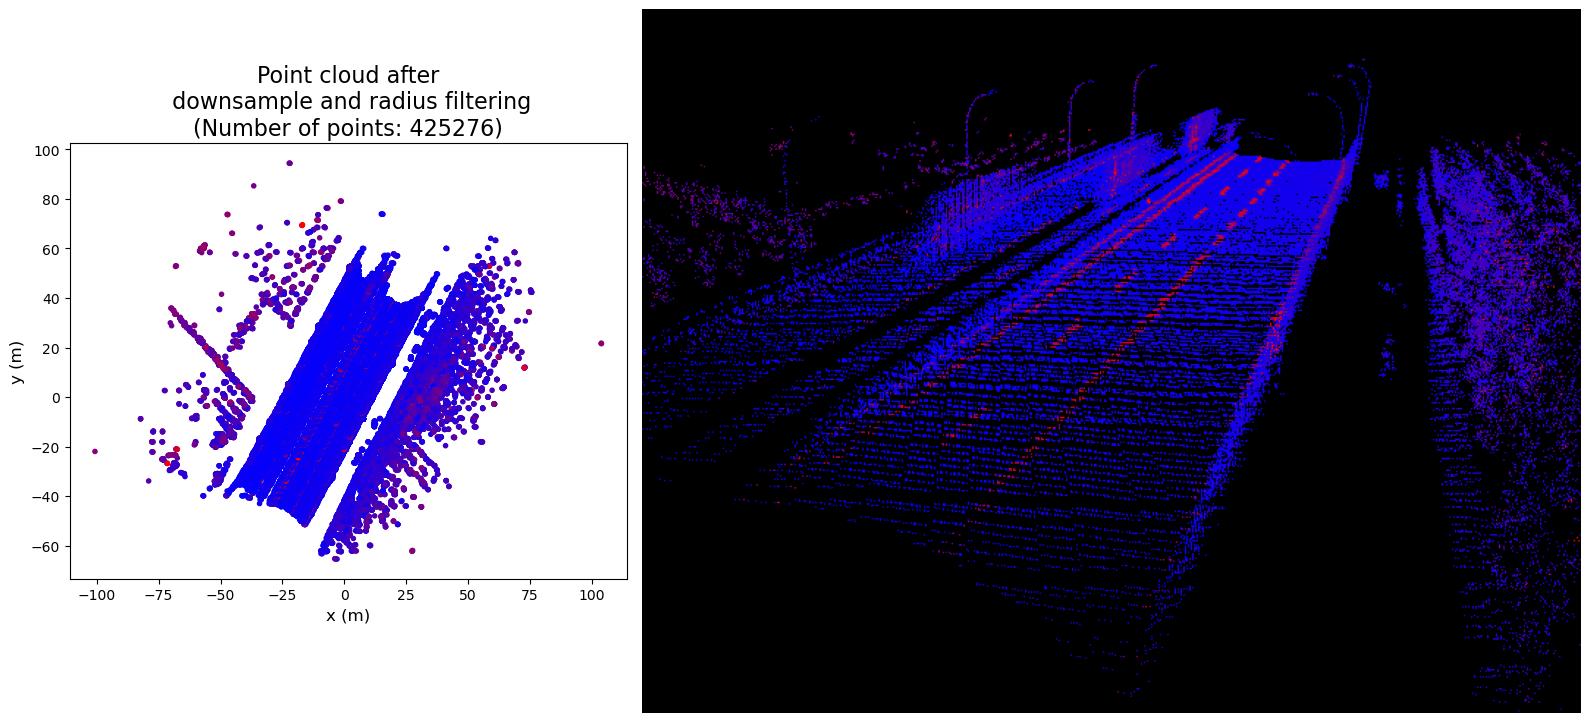

In [7]:
# Plot and save
plot_cloud_2d3d(xyza, title='Point cloud after\n downsample and radius filtering')
write_cloud_and_figure('result/2_xyza.pcd', xyza)
plt.show()

# Get planar regions 
## (i.e., remove regions with large thickness in z axis)

In [8]:
t0 = time.time()
method = ['grid', 'kdtree'][1]

if method == 'grid': # Not so good result, but fast
    inliers = find_plannar_points_by_grid(xyza, grid_size=0.5, max_height=0.1)
    # time: 1s
    
elif method == 'kdtree': # Good result, but slow
    inliers = find_plannar_points_by_kdtree(xyza, num_neighbors=10, max_height=0.1)
    # time: 78s
    
xyza_planar = xyza[inliers, :]

print("\n\nTime cost of {} method: {:.2f} s".format(method, time.time()-t0))
print("Removing non-planar regions:\n{} --> {}".format(
    xyza.shape[0], xyza_planar.shape[0]))

2000/425276, 4000/425276, 6000/425276, 8000/425276, 10000/425276, 12000/425276, 14000/425276, 16000/425276, 18000/425276, 20000/425276, 22000/425276, 24000/425276, 26000/425276, 28000/425276, 30000/425276, 32000/425276, 34000/425276, 36000/425276, 38000/425276, 40000/425276, 42000/425276, 44000/425276, 46000/425276, 48000/425276, 50000/425276, 52000/425276, 54000/425276, 56000/425276, 58000/425276, 60000/425276, 62000/425276, 64000/425276, 66000/425276, 68000/425276, 70000/425276, 72000/425276, 74000/425276, 76000/425276, 78000/425276, 80000/425276, 82000/425276, 84000/425276, 86000/425276, 88000/425276, 90000/425276, 92000/425276, 94000/425276, 96000/425276, 98000/425276, 100000/425276, 102000/425276, 104000/425276, 106000/425276, 108000/425276, 110000/425276, 112000/425276, 114000/425276, 116000/425276, 118000/425276, 120000/425276, 122000/425276, 124000/425276, 126000/425276, 128000/425276, 130000/425276, 132000/425276, 134000/425276, 136000/425276, 138000/425276, 140000/425276, 142

(358501, 4)
Time cost of plotting 2D/3D point cloud = 0.62 seconds


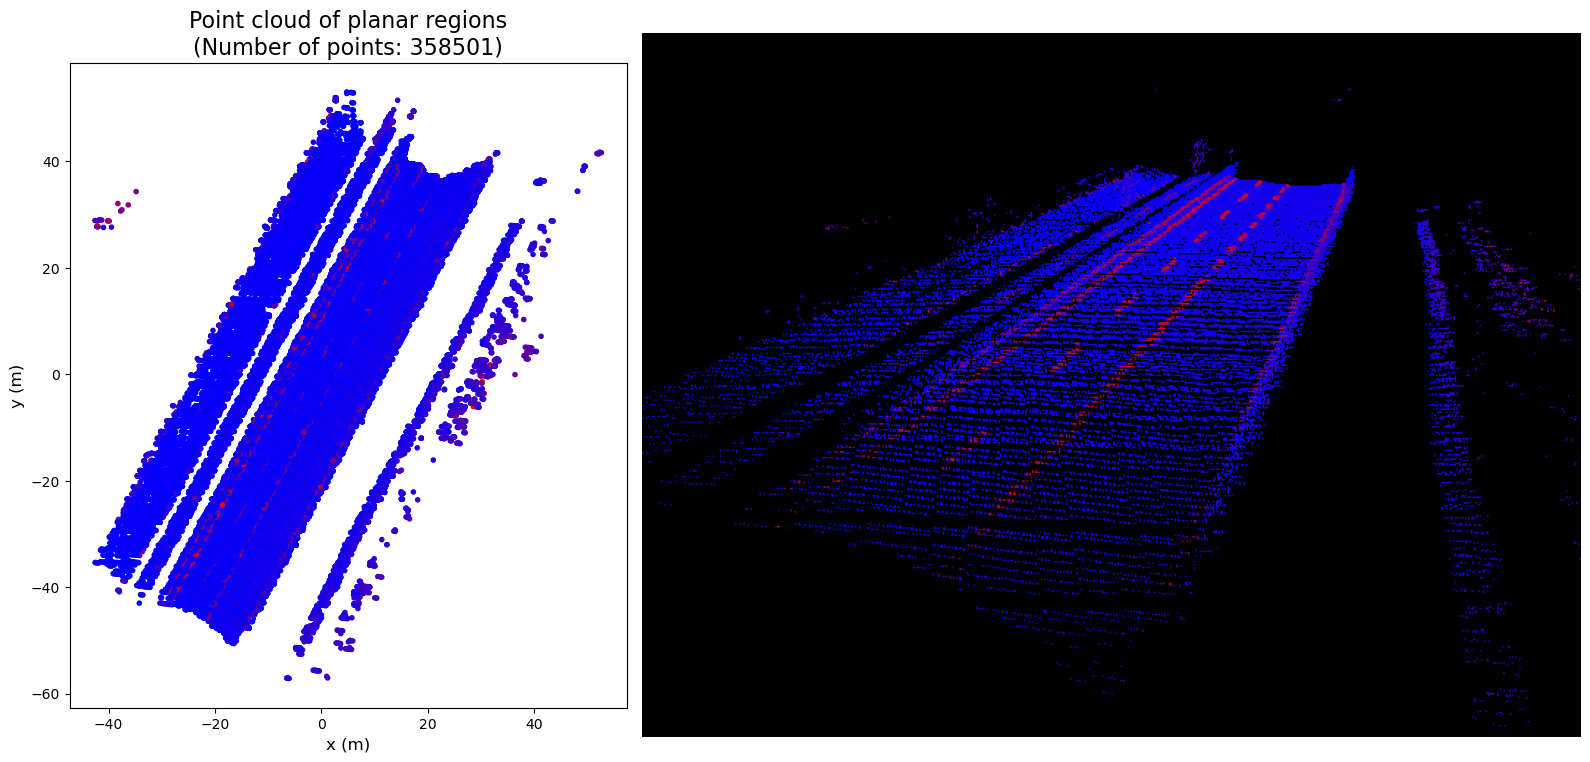

In [9]:
# Plot and save
plot_cloud_2d3d(xyza_planar, title='Point cloud of planar regions')
write_cloud_and_figure('result/3_xyza_planar', xyza_planar)
plt.show()

# Fit road plane by RANSAC

In [10]:
points_xyz = xyza_planar[:,0:3]
plane_model = PlaneModel(feature_dimension=3)
w, inliers = ransac(
    points_xyz,
    plane_model, 
    n_pts_base=3,
    n_pts_extra=50,
    max_iter=100,
    dist_thre=0.3,
    print_time=True,
    debug=False,
)
print("Plane fitting: {} --> {}".format(points_xyz.shape[0], inliers.size ))
xyza_plane = xyza_planar[inliers, :]


--------------------------------
Start RANSAC algorithm ...
Input: num points = 358501, features dim = 3
Config: n_pts_base = 3, n_pts_extra = 50, dist_thre = 0.3

2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 
Time cost for RANSAC = 7.836 seconds
--------------------------------

Plane fitting: 358501 --> 319630


(319630, 4)
Time cost of plotting 2D/3D point cloud = 0.56 seconds


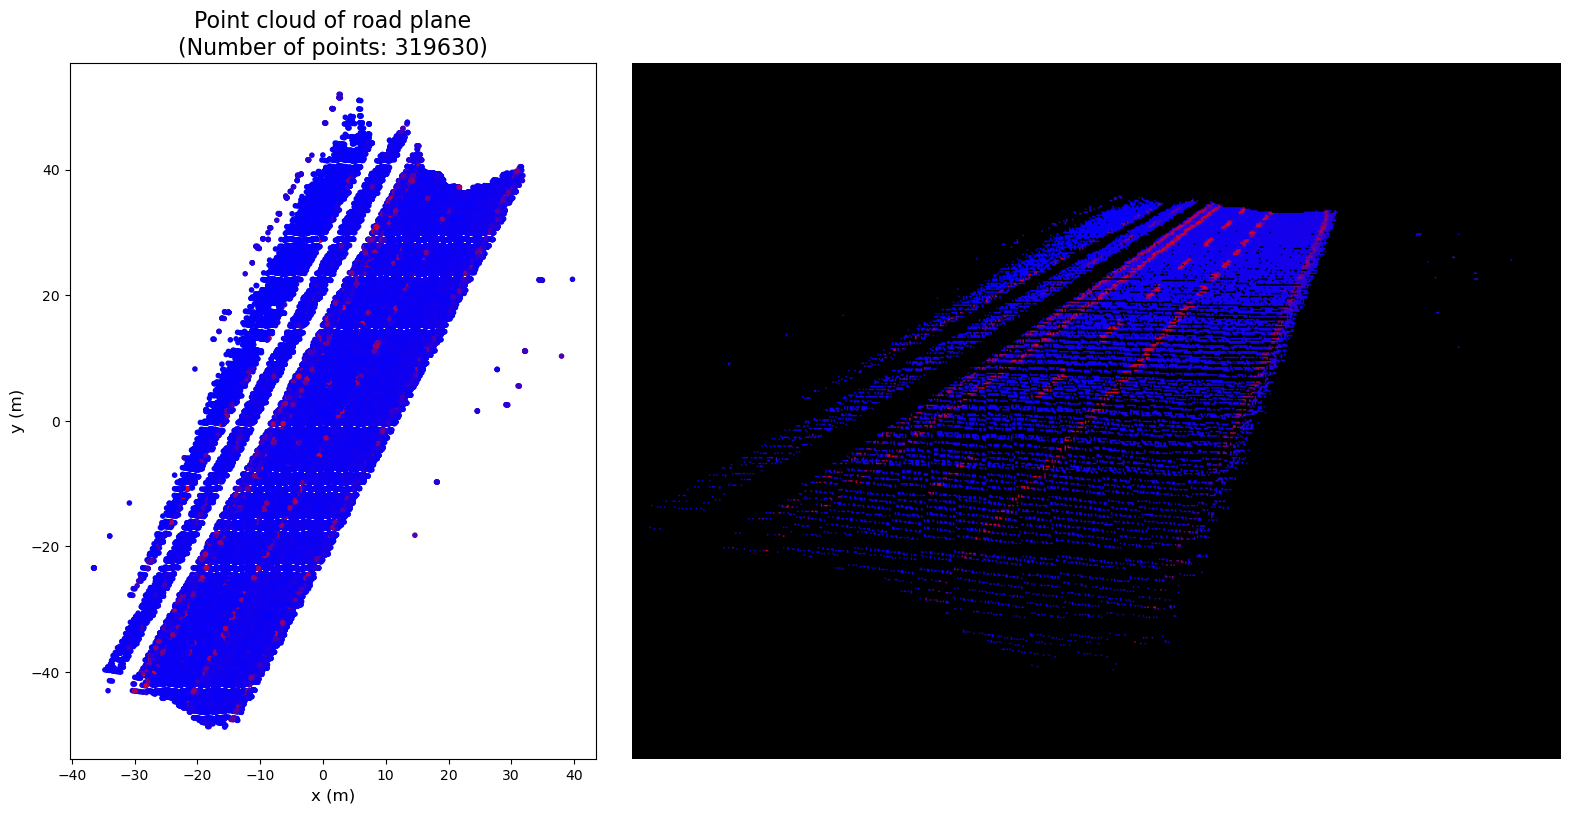

In [11]:
# Plot and save
plot_cloud_2d3d(xyza_plane, title='Point cloud of road plane')
write_cloud_and_figure("result/4_xyza_plane", xyza_plane)
plt.show()

# Threshold on point intensity to get possible lane points

In [12]:
threshold = 0.5
xyza_lanes = xyza_plane[xyza_plane[:, -1]>threshold, :]

print("Threshold on intensity: {} --> {}".format(xyza_plane.shape[0], xyza_lanes.shape[0] ))

Threshold on intensity: 319630 --> 7135


(7135, 4)


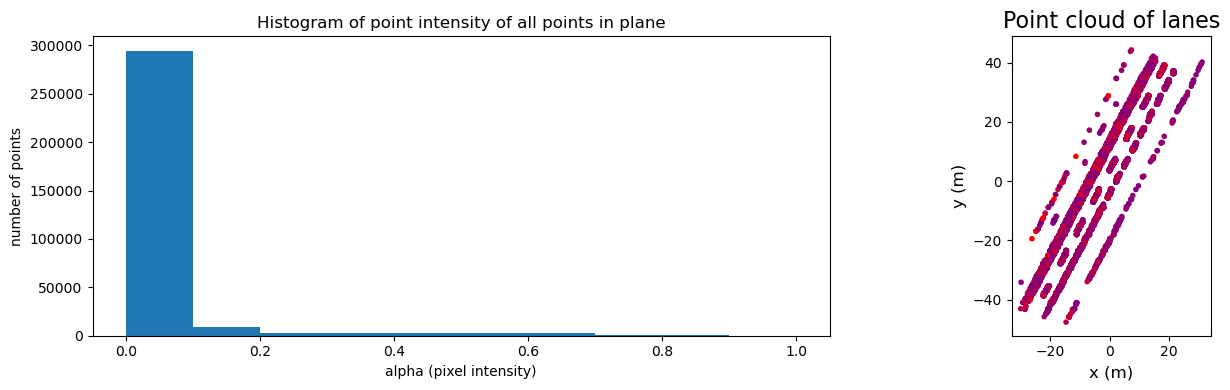

In [13]:
# Plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Left: histogram of point intensity
ax1.hist(xyza_plane[:,-1], bins=10, range=(0, 1))
ax1.set_title('Histogram of point intensity of all points in plane')
ax1.set_xlabel('alpha (pixel intensity)')
ax1.set_ylabel('number of points')

# Right point cloud of lanes
plot_cloud_2d(xyza_lanes, ax=ax2, title='Point cloud of lanes')
f.tight_layout()

# Plot and save
write_cloud_and_figure("result/5_xyza_lanes", xyza_lanes)
plt.show()

# Use RANSAC to find lane direction


--------------------------------
Start RANSAC algorithm ...
Input: num points = 7135, features dim = 2
Config: n_pts_base = 2, n_pts_extra = 10, dist_thre = 0.3


Time cost for RANSAC = 0.548 seconds
--------------------------------

Line fitting: 7135 --> 3134
(3134, 4)
Time cost of plotting 2D/3D point cloud = 0.04 seconds


(<Axes: title={'center': 'Line fitting\n(Number of points: 3134)'}, xlabel='x (m)', ylabel='y (m)'>,
 <Axes: >)

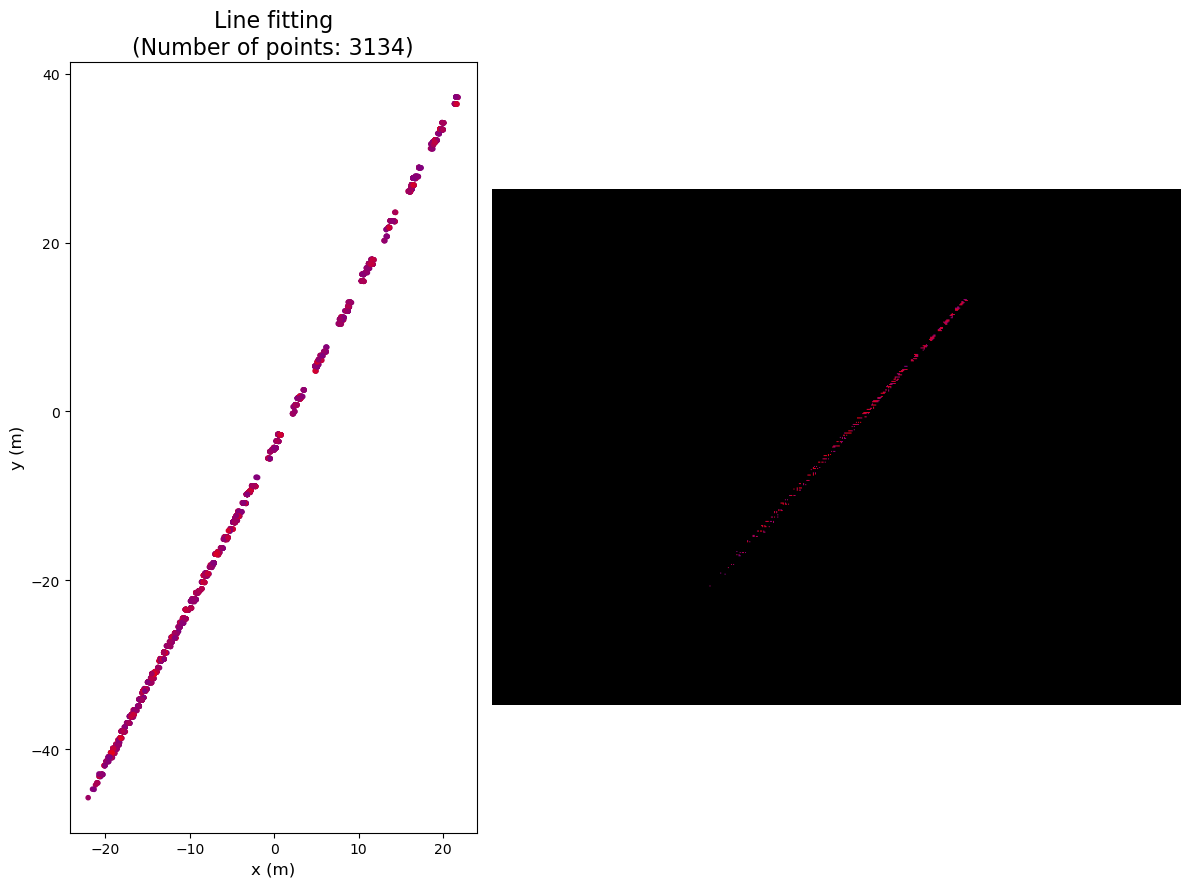

In [14]:
points_xy = xyza_lanes[:,0:2]
line_model = PlaneModel(feature_dimension=2)
w, inliers = ransac(
    points_xy,
    line_model, 
    n_pts_base=2,
    n_pts_extra=10,
    max_iter=1000,
    dist_thre=0.3,
    print_time=True,
    print_iter=False,
    debug=False,
)
print("Line fitting: {} --> {}".format(points_xy.shape[0], inliers.size ))
xyza_lane = xyza_lanes[inliers, :]

plot_cloud_2d3d(xyza_lane, figsize=(12, 12), title="Line fitting")

# Project points to normal of lane, and do clustering
### (Projection is same as squashing the points along the lane direction)

In [15]:
# Project points

# get line's normal from line parameters w 
# w: w[0] + w[1]*x + w[2]*y = 0
norm_direction = w[1:]
print("Normal of lane: {}".format(norm_direction))

# project points
x = points_xy.dot(norm_direction)
y = np.zeros_like(x)
projections = np.column_stack((x, y))

Normal of lane: [-0.88486607  0.46584551]


In [16]:
# Do clustering

# settings
min_points_in_a_lane = 10
max_width_of_a_lane = 0.2 # (meters)

# do clusttering
cluster = Clusterer()
cluster.fit(
    projections, 
    eps=max_width_of_a_lane, 
    min_samples=min_points_in_a_lane)
print("Number of clusters (lanes): ", cluster.n_clusters)

Number of clusters (lanes):  7


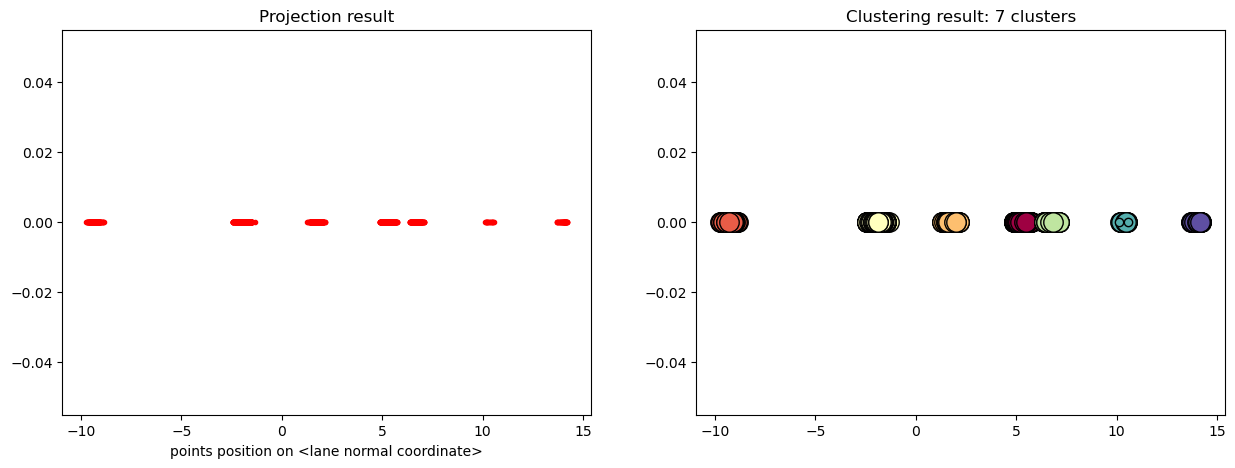

In [17]:
# Plot
fig = plt.figure(figsize=(15, 5))

# Plot left: Projection result
plt.subplot(1,2,1)
plt.scatter(projections[:,0], projections[:,1], marker='.', color='r')
plt.title('Projection result')
plt.xlabel('points position on <lane normal coordinate>')

# Plot right: Clustering result
plt.subplot(1,2,2)
cluster.plot_clusters()

# Plot and save
plt.savefig('result/7_projected_points_and_clustering.jpg')
plt.show()

# Fit a 3D line to each cluster

In [18]:
N = cluster.n_clusters # Number of lanes
lanes_param = []

for i in range(N):
    # Get points of label i
    indices = (cluster.labels == i)
    points = xyza_lanes[indices, :].copy()
    
    # Fit line
    x, y, z, alpha = split_into_columns(points)
    lane_direction, a_point_on_lane = fit_3D_line(x, y, z)
    lanes_param.append((lane_direction, a_point_on_lane))
    
    # Print result
    print("\n{}th line, {} points.".format(i+1, points.shape[0]))
    print("Equation: {}".format(
        get_3d_line_equation(lane_direction, a_point_on_lane)
    ))


1th line, 1416 points.
Equation: (x+5.04)/(0.46480) == (y-1.82)/(0.88542) == (z-225.29)/(0.00073)

2th line, 280 points.
Equation: (x-4.03)/(-0.46510) == (y+12.36)/(-0.88526) == (z-224.86)/(-0.00056)

3th line, 1488 points.
Equation: (x+2.17)/(-0.46568) == (y+0.39)/(-0.88496) == (z-225.19)/(-0.00080)

4th line, 3348 points.
Equation: (x+3.84)/(0.46647) == (y+11.39)/(0.88454) == (z-225.07)/(0.00057)

5th line, 532 points.
Equation: (x+7.08)/(0.46514) == (y-0.97)/(0.88524) == (z-225.29)/(0.00101)

6th line, 19 points.
Equation: (x+10.58)/(-0.46762) == (y-2.10)/(-0.88393) == (z-225.19)/(-0.00123)

7th line, 52 points.
Equation: (x+13.44)/(0.46594) == (y-4.56)/(0.88482) == (z-225.10)/(0.00106)


Number of clusters (lanes):  1


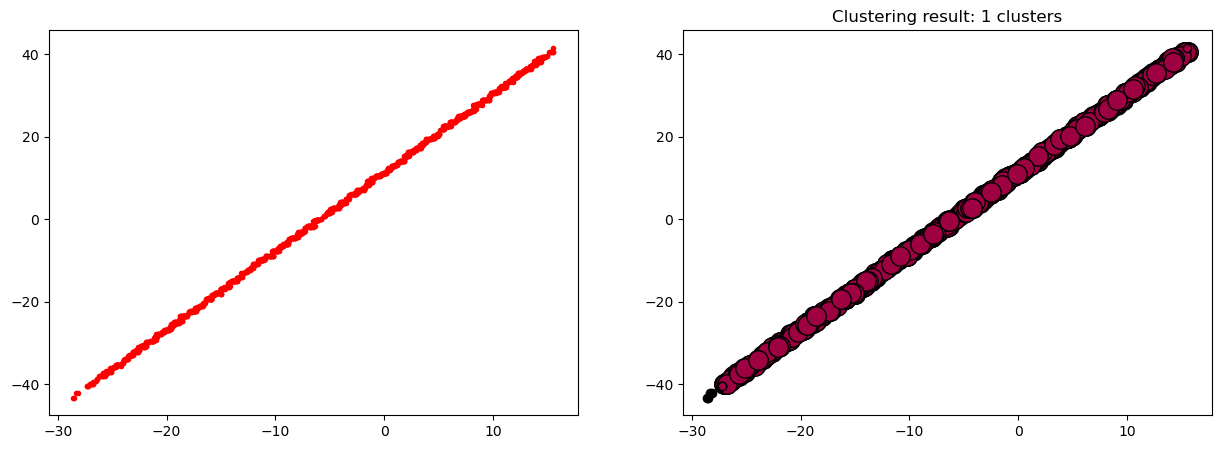

Number of clusters (lanes):  2


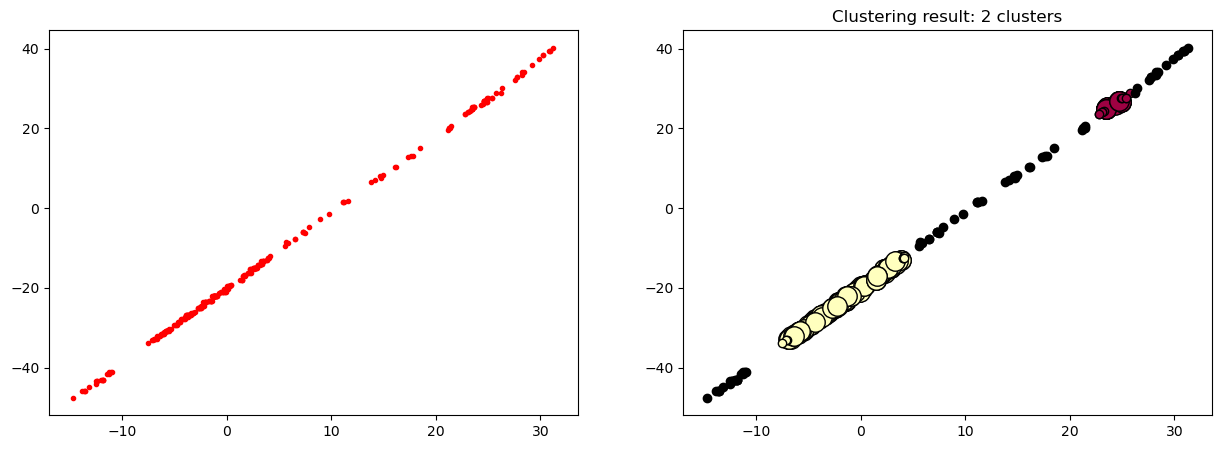

Number of clusters (lanes):  8


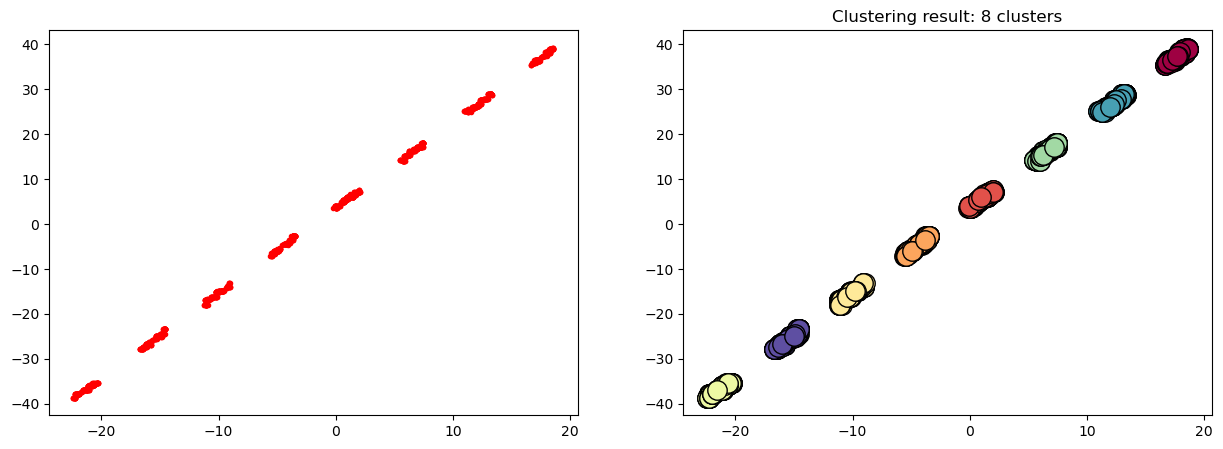

Number of clusters (lanes):  10


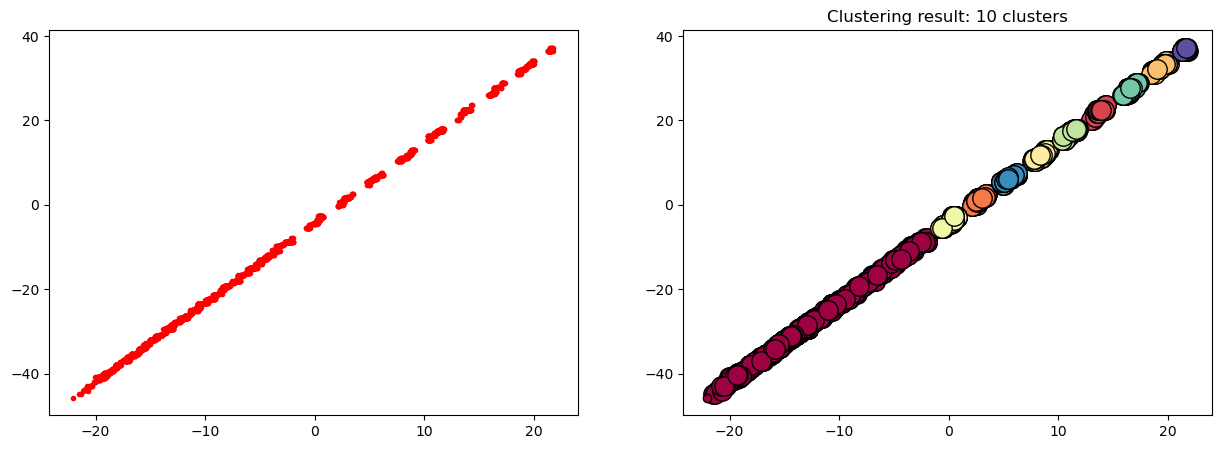

Number of clusters (lanes):  1


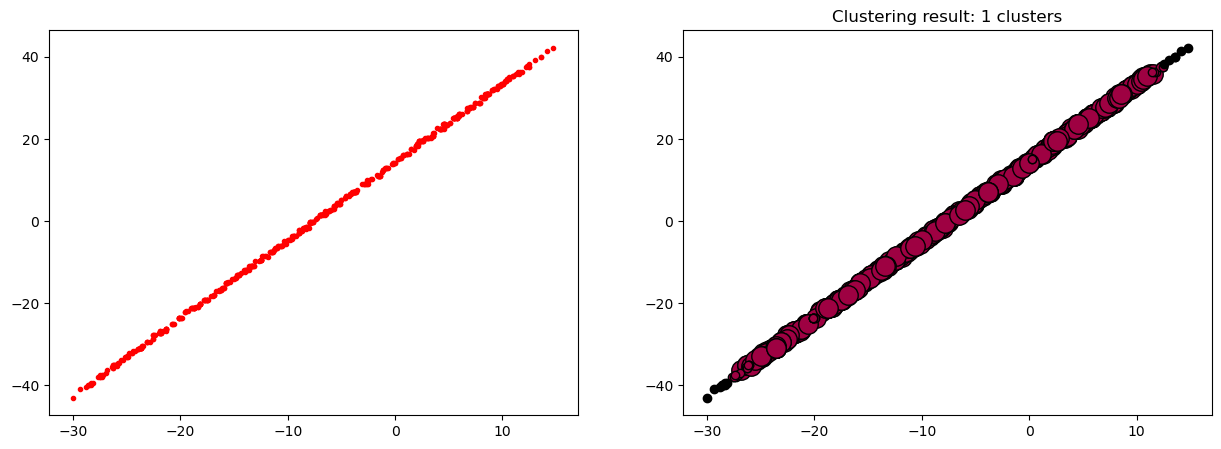

Number of clusters (lanes):  0


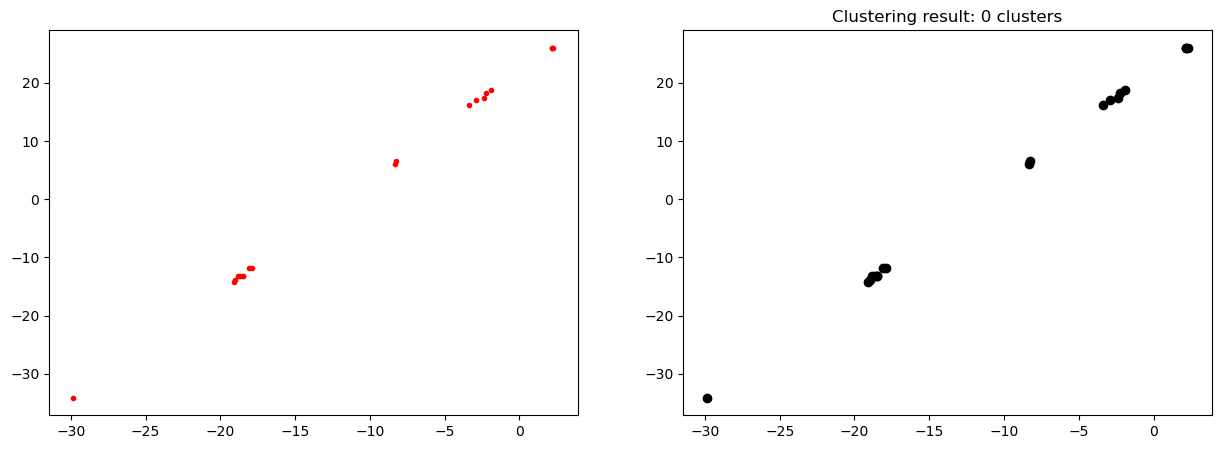

Number of clusters (lanes):  0


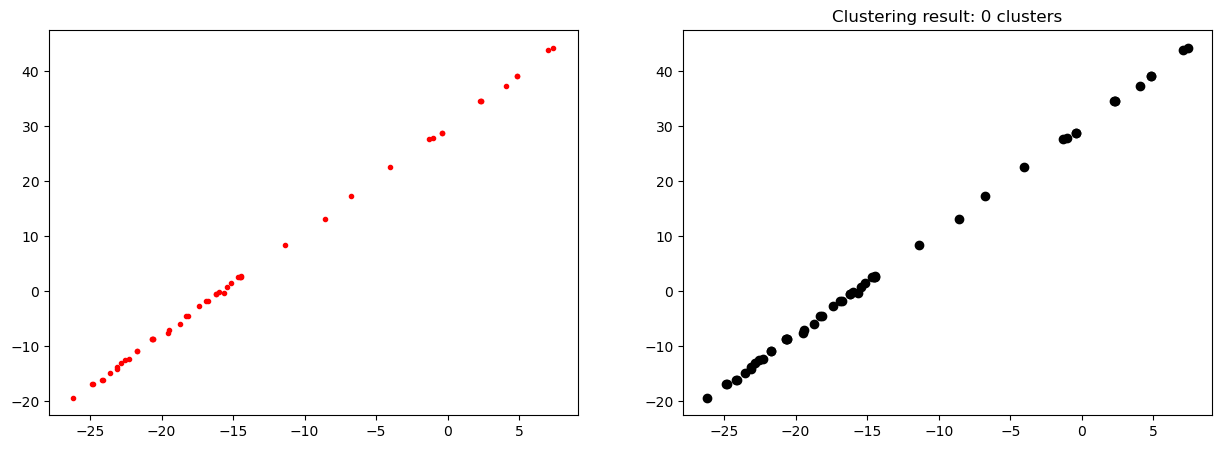

In [49]:
# 各車道線分群並取各群的最遠兩個點
N = cluster.n_clusters
each_line_clustering = {}

# 各車道線
for i in range(N):
    indices = (cluster.labels == i)
    points = xyza_lanes[indices, :].copy()  # 原始資料，包括 x, y, z 和 a
    points_xy = points[:, :2]  # 只取 x 和 y 進行分群

    line_cluster = Clusterer()
    line_cluster.fit(points_xy, eps=2.5, min_samples=20)
    clusters_number = line_cluster.n_clusters
    print("Number of clusters (lanes): ", clusters_number)

    # 儲存每個主分群 i 中的子分群
    each_line_clustering[i] = {}

    # 車道線中各群
    for j in range(clusters_number):
        each_line_clustering[i][j] = line_cluster.get_cluster_data(j)  # 取得該分群的點 (僅有 x 和 y)
        # print(len(each_line_clustering[i][j]))

    # 繪圖
    fig = plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(points[:, 0], points[:, 1], marker='.', color='r')
    plt.subplot(1, 2, 2)
    line_cluster.plot_clusters()
    plt.show()

In [73]:
from scipy.spatial import distance, ConvexHull
from sklearn.decomposition import PCA

def get_farthest_points(cluster_data):
    """找到該分群中距離最遠的兩個點"""
    max_distance = 0
    point1, point2 = None, None
    
    # 計算所有點之間的距離
    for i in range(len(cluster_data)):
        for j in range(i + 1, len(cluster_data)):
            dist = distance.euclidean(cluster_data[i], cluster_data[j])
            if dist > max_distance:
                max_distance = dist
                point1, point2 = cluster_data[i], cluster_data[j]
    
    # return point1, point2, max_distance
    return point1, point2

def get_corner_points(cluster_data):
    """找到該分群中四個角落的點，並取長邊的兩個中點座標"""
    hull = ConvexHull(cluster_data[:, :2]) 
    hull_points = cluster_data[hull.vertices]

    min_x_point = hull_points[np.argmin(hull_points[:, 0])]
    max_x_point = hull_points[np.argmax(hull_points[:, 0])]
    min_y_point = hull_points[np.argmin(hull_points[:, 1])]
    max_y_point = hull_points[np.argmax(hull_points[:, 1])]

    min_center = (min_x_point + min_y_point) / 2
    max_center = (max_x_point + max_y_point) / 2
    return min_center, max_center


    length_x = distance.euclidean(max_x_point, min_x_point)
    length_y = distance.euclidean(max_y_point, min_y_point)
    
    # 返回 x 邊或 y 邊的中點
    if length_x > length_y:
        return max_x_point, min_x_point
    else:
        return max_y_point, min_y_point

def get_PCA_points(cluster_data):
    hull = ConvexHull(cluster_data[:, :2]) 
    hull_points = cluster_data[hull.vertices]

    # 使用 PCA 來計算主要趨勢方向
    pca = PCA(n_components=2)
    pca.fit(cluster_data)
    mean = pca.mean_  # 點雲的中心
    components = pca.components_  # 特徵向量
    explained_variance = pca.explained_variance_  # 特徵值

    direction = components[0]  # 主要趨勢方向

    # 將凸包上的點投影到主要趨勢方向
    projections = np.dot(hull_points - mean, direction)

    # 計算長邊的長度
    min_proj_point = hull_points[np.argmin(projections)]
    max_proj_point = hull_points[np.argmax(projections)]
    long_edge_length = np.linalg.norm(max_proj_point - min_proj_point)

    line_start = mean - direction * (long_edge_length / 2)
    line_end = mean + direction * (long_edge_length / 2)
    return line_start, line_end



In [74]:
clustering_corner_points = {}
for i in each_line_clustering:
    clustering_corner_points[i] = {}
    indices = (cluster.labels == i)
    points = xyza_lanes[indices, :].copy()  # 原始資料，包括 x, y, z 和 a
    points_xy = points[:, :2]  # 只取 x 和 y 進行分群
    for j in each_line_clustering[i]:
        # 取得各群的所有點
        ps = each_line_clustering[i][j]

        # 找回這些點的 z 和其他資料
        original_points_in_cluster = []
        for point_xy in ps:
            mask = np.all(points[:, :2] == point_xy, axis=1)
            if np.any(mask):
                original_point = points[mask][0]
                original_points_in_cluster.append(original_point)

        original_points_in_cluster = np.array(original_points_in_cluster)

        if len(original_points_in_cluster) > 1:
            # line_points = get_farthest_points(original_points_in_cluster)  # 獲取角落點
            # line_points = get_corner_points(original_points_in_cluster)  # 獲取角落點
            line_points = get_PCA_points(original_points_in_cluster)  # 獲取趨勢線

            clustering_corner_points[i][j] = line_points
# print(clustering_corner_points)

# Add fitted line to point cloud, and display

In [75]:
# Generate data points on each of the fitted line
points_of_each_lane = []
for i, lane_param in enumerate(lanes_param):
    vec, p0 = lane_param
    line_pts = p0 + vec * np.mgrid[-80:80:12000j][:, np.newaxis]
    points_of_each_lane.append(line_pts)

# Add these line points to the point cloud of the street
lines_pts = np.vstack(points_of_each_lane)
n = lines_pts.shape[0]
lines_pts_with_alpha = np.hstack((lines_pts, np.ones((n, 1))))
xyza_final = np.vstack((xyza, lines_pts_with_alpha))

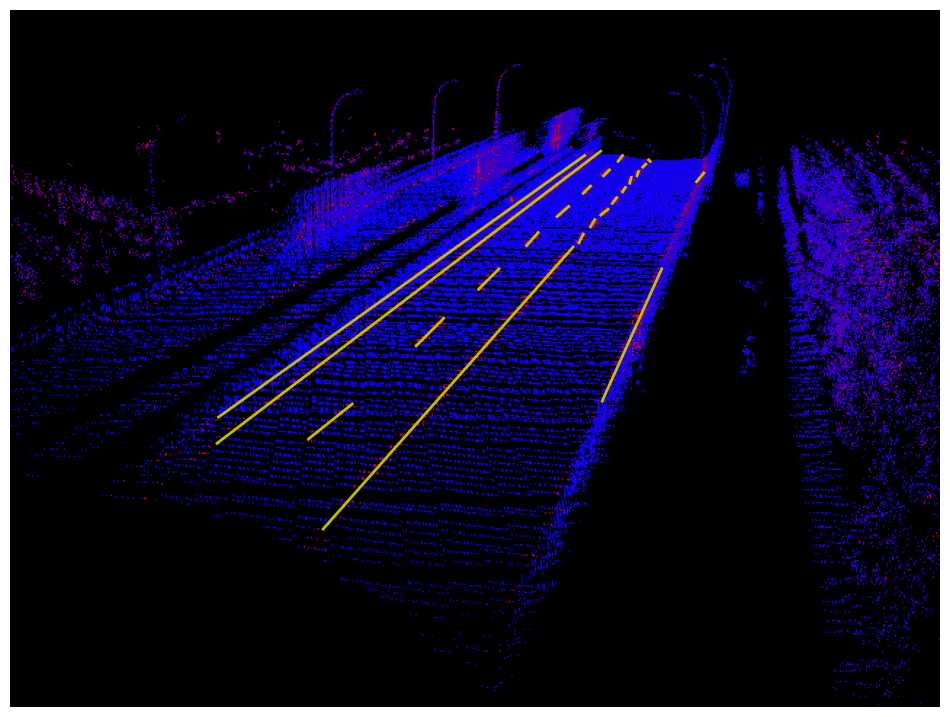

In [76]:
fig, ax = plt.subplots(figsize=(12, 12))

for i in clustering_corner_points:
    for j in clustering_corner_points[i]:
        farthest_points = clustering_corner_points[i][j]
        head_pts = np.array(farthest_points[0][:3])
        tail_pts = np.array(farthest_points[1][:3])
        # print(head_pts, tail_pts)
        
        plot_2d_line_from_3d(
            xyza=xyza,
            head_pts=head_pts,
            tail_pts=tail_pts,
            ax=ax
        )


(509276, 4)
Time cost of plotting 2D/3D point cloud = 0.79 seconds


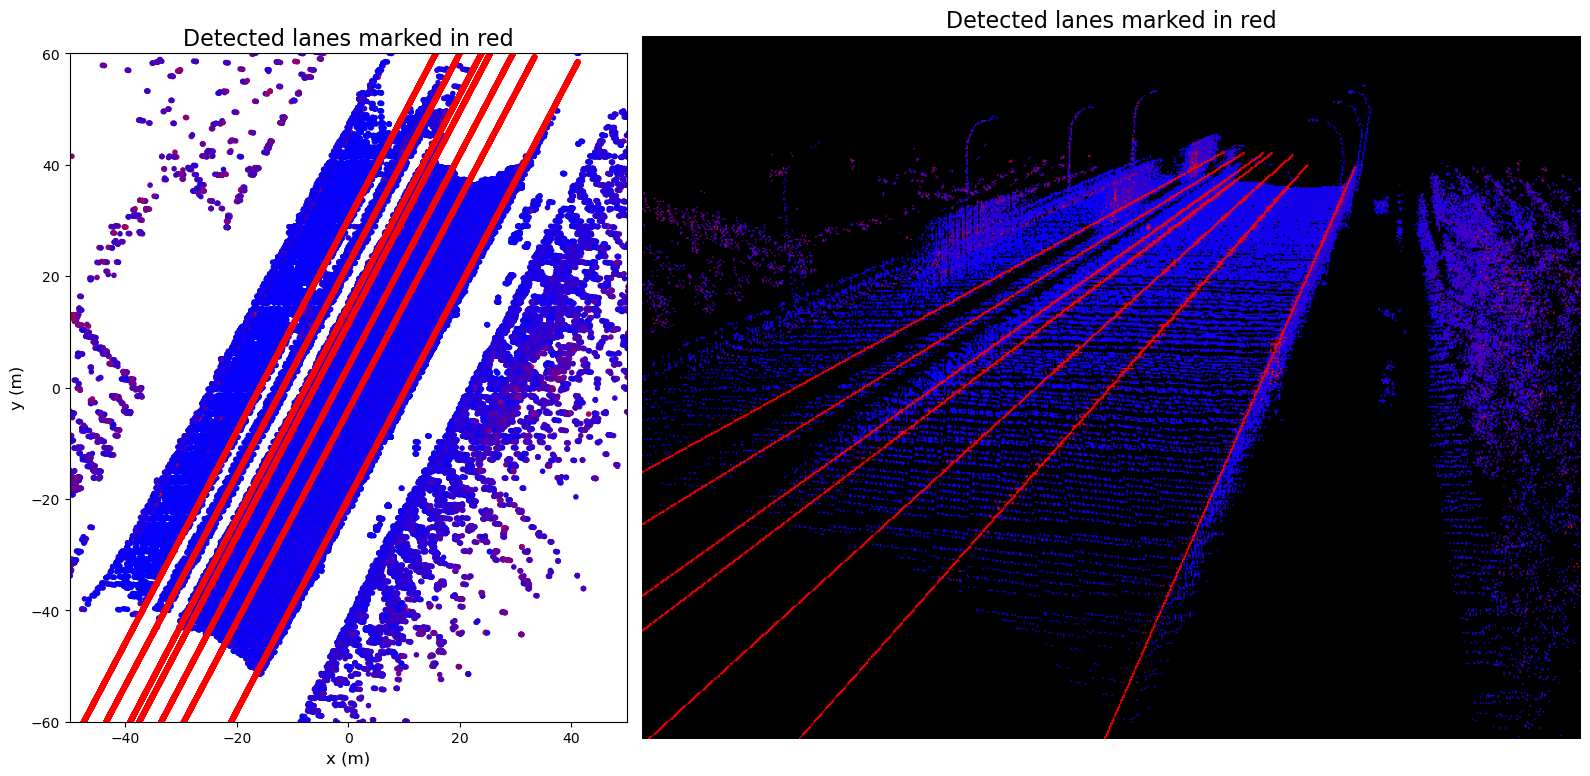

In [77]:
# Plot and save
ax1, ax2 = plot_cloud_2d3d(xyza_final)
ax1.set_title('Detected lanes marked in red', fontsize=16)
ax1.set_xlim([-50, 50])
ax1.set_ylim([-60, 60])
ax2.set_title('Detected lanes marked in red', fontsize=16)
write_cloud_and_figure('result/8_xyza_final', xyza_final)
plt.show()

# Draw raw cloud for comparison

(430736, 4)
Time cost of plotting 2D/3D point cloud = 0.74 seconds


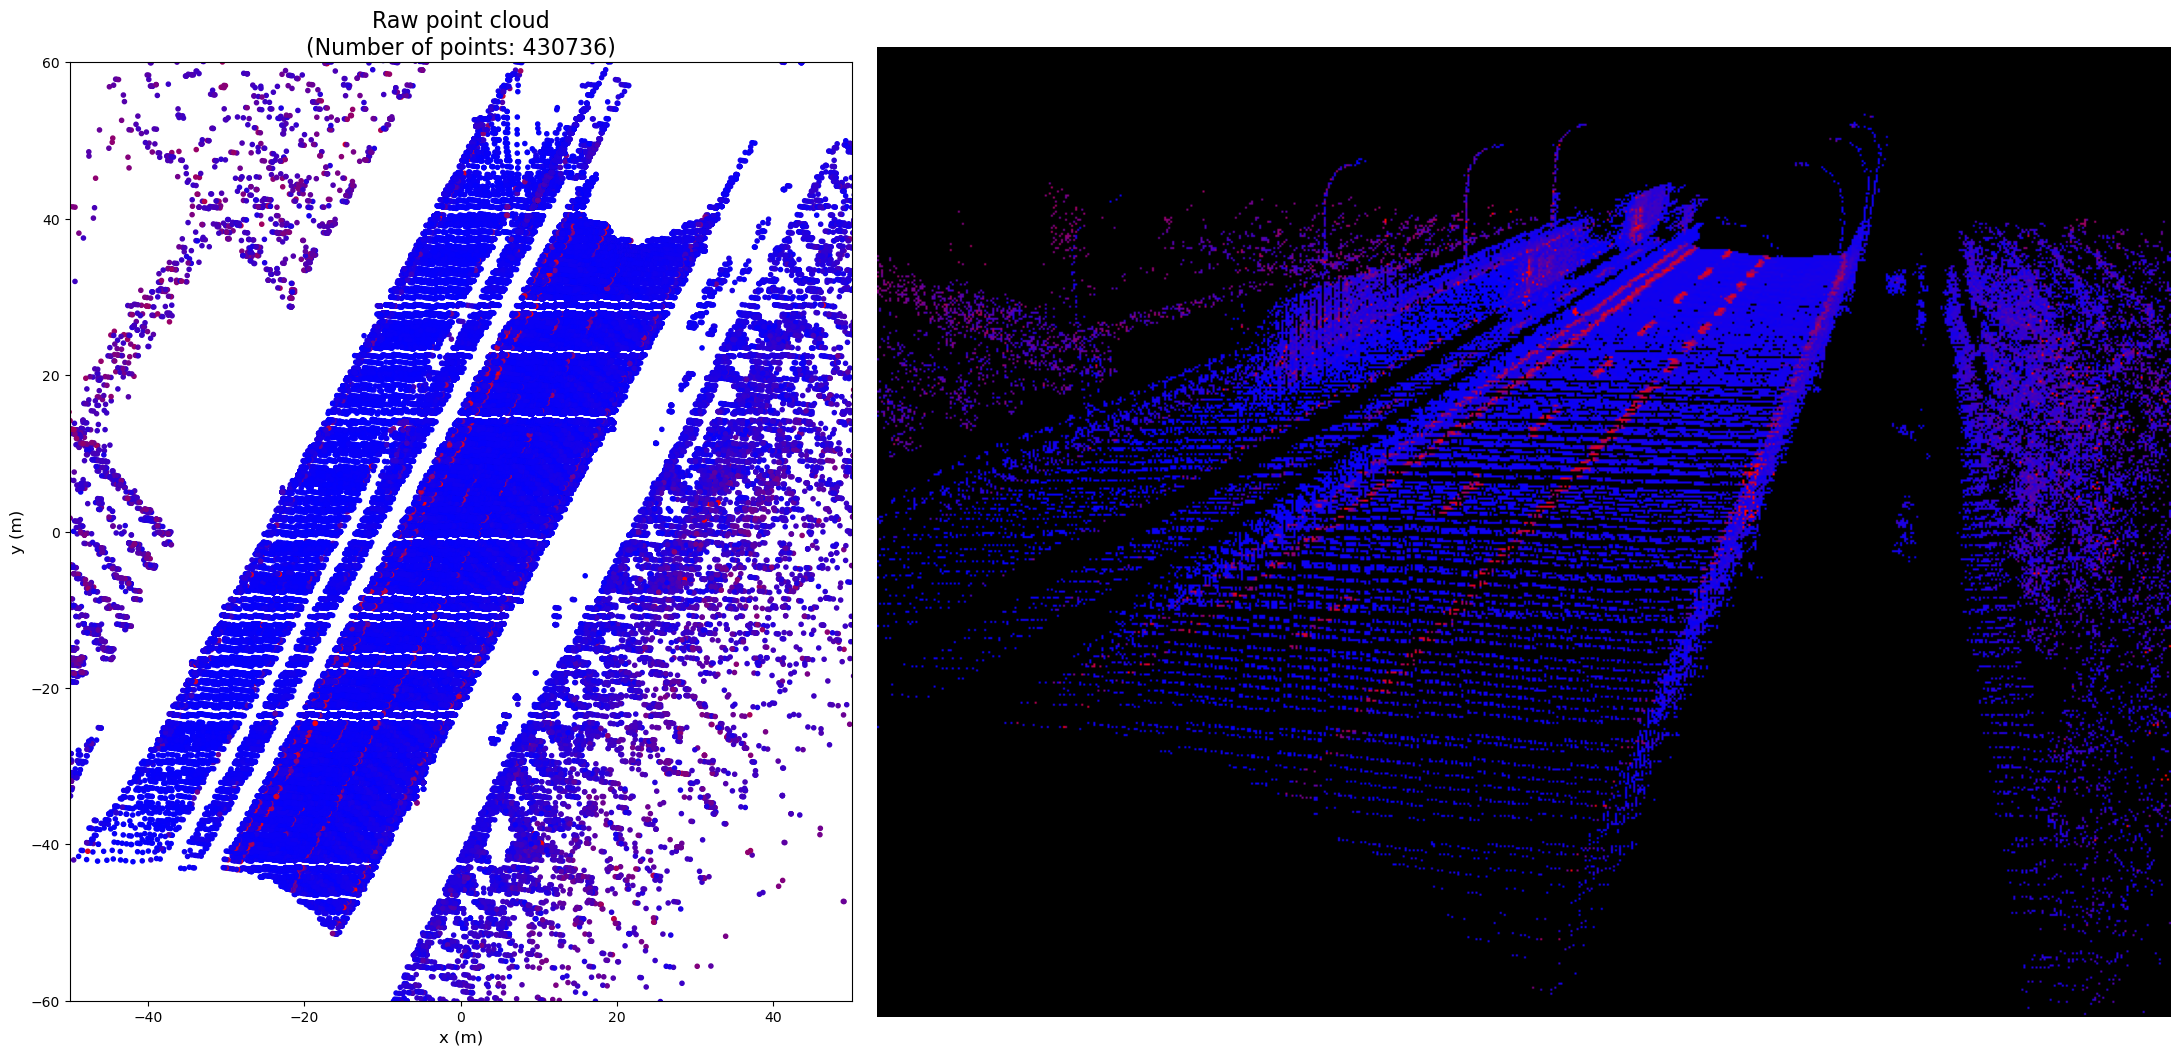

In [25]:
# Plot and save
ax1, ax2 = plot_cloud_2d3d(xyza_src, figsize=(22, 10), title='Raw point cloud')
ax1.set_xlim([-50, 50])
ax1.set_ylim([-60, 60])
write_cloud_and_figure('result/8_xyza_src', xyza_src)
plt.show()

In [26]:
print("Total time of running this jupyter notebook = {:.2f}s".format(
    time.time() - t_start_running_this_jupyter_notebook))

Total time of running this jupyter notebook = 78.70s
